In [65]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata
from fastai import *
import pandas as pd

In [66]:
from fastai.tabular import *

In [67]:
path = Path('data_fcn')

In [68]:
train_df=pd.read_pickle('orig_df_fixed_normalized_910.pkl')

In [69]:
from sklearn.utils import shuffle
train_df = shuffle(train_df)

In [70]:
procs=[Categorify]


In [71]:
cat_vars = ['atom_name', 'residue_name', 'chain_id',
       'residue_number','element_symbol']

In [72]:
cont_vars = ['x_ca', 'y_ca', 'z_ca']

In [73]:
valid_idx = range(20000)

In [74]:
dep_var = ['x_coord', 'y_coord', 'z_coord']

In [75]:
y=train_df[dep_var]


In [76]:
y

,x_coord,y_coord,z_coord
151,-0.969668,-0.232170,0.097853
200,0.656312,1.042091,0.000597
851,-0.745368,-0.625978,0.834195
2266,0.650579,-0.674467,-0.767813
1138,-0.723871,-1.784077,0.568223
1516,-0.382765,0.707010,0.198773
322,-0.539348,0.740935,-0.701776
298,1.625885,0.858196,0.771093
1125,1.034646,1.758857,-0.893107
473,-0.113791,-0.409918,-0.880762


In [77]:
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList)
                   .databunch(bs = 32))

In [78]:
data.show_batch()

atom_name,residue_name,chain_id,residue_number,element_symbol,x_ca,y_ca,z_ca,target
N,THR,657,295,N,0.0759,1.1116,-0.2339,[ 0.007152 1.051283 -0.212405]
N,THR,3,98,N,0.9747,0.8254,-0.7200,[ 0.875932 0.697248 -0.696621]
O,HIS,42,59,O,0.7943,-0.6522,-0.5492,[ 0.477465 -0.686776 -0.725214]
OE2,GLU,355,88,O,-0.0758,1.5068,-1.6902,[ 0.476995 1.723527 -1.829342]
OE2,GLU,8,74,O,1.5012,1.0832,-1.0199,[ 1.049967 1.399399 -0.973902]


In [79]:
emb_szs = data.get_emb_szs()
emb_szs

[(83, 19), (21, 9), (721, 64), (591, 57), (6, 4)]

In [80]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, n_channels=128, kernel_size=8, dropout=0.0):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=in_channels,
                             out_channels=n_channels,
                             kernel_size=kernel_size)
        self.bn = nn.BatchNorm1d(num_features=n_channels)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # input size should be batch, input_size, length = 64, 1, 312 at first
        x = self.conv(x)
        # now batch, n_channels, L
        x = self.bn(x)
        x = F.relu(x)
        # output will be bs, n_filters, L (not equal to inital L)
        return self.dropout(x)

In [81]:
class TabularCNNModel(nn.Module):
    
    def __init__(self, emb_szs:ListSizes, n_cont:int, out_sz:int, layers:Collection[int], ps:Collection[float]=None,
                 emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False , 
                conv_n_channels = [128, 256, 1],conv_kernel_sizes = [3, 3, 3]):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(emb_drop)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        self.conv1 = ConvLayer(1, conv_n_channels[0], conv_kernel_sizes[0])  
        self.conv2 = ConvLayer(conv_n_channels[0], conv_n_channels[1], conv_kernel_sizes[1])  
        self.conv3 = ConvLayer(conv_n_channels[1], conv_n_channels[2], conv_kernel_sizes[2])
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)
        self.adaptive = nn.AdaptiveAvgPool1d(156)
        self.lin126 = nn.Linear(in_features=16128,out_features=126)
        

    def get_sizes(self, layers, out_sz):
        return [self.n_emb + self.n_cont] + layers + [out_sz]

    def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = x.view(32,1,-1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
#         x = x.view(64,-1)
#         x = self.lin129(x)
        x = self.adaptive(x)
        
        x = x.view(-1,156)
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x



In [82]:
model = TabularCNNModel(emb_szs=emb_szs,out_sz=3,layers=[1000,500],n_cont=len(cont_vars),ps=[0.01,0.1],)

In [83]:
loss = F.mse_loss

In [84]:
learn = Learner(data,model,loss_func= loss)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


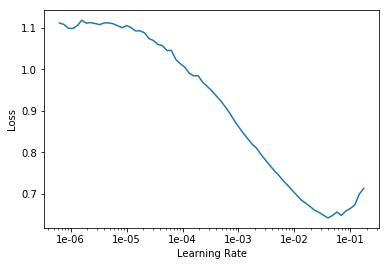

In [85]:
learn.lr_find()
learn.recorder.plot()

In [88]:
learn.fit_one_cycle(5,max_lr=slice(4e-4))

epoch,train_loss,valid_loss
1,0.068533,0.042671
2,0.073590,0.084895
3,0.067290,0.033926
4,0.069143,0.034045
5,0.064067,0.035642


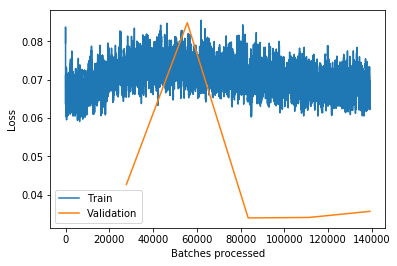

In [89]:
learn.recorder.plot_losses()

In [90]:
# learn.load('cnn_lin')

In [91]:
learn.save('cnn_lin')

In [92]:
learn.show_results(rows=20)

atom_name,residue_name,chain_id,residue_number,element_symbol,x_ca,y_ca,z_ca,target,prediction
CE2,PHE,292,21,C,-1.3177,-0.6158,-0.0723,[-0.969668 -0.23217 0.097853],[-0.838414 -0.540493 -0.085119]
CG,GLU,134,28,C,0.3904,0.9429,-0.1462,[6.563119e-01 1.042091e+00 5.971520e-04],[ 0.415894 0.944534 -0.223239]
N,LEU,435,113,N,-0.7536,-0.6069,0.6312,[-0.745368 -0.625978 0.834195],[-0.705494 -0.613681 0.524119]
CD2,LEU,165,288,C,0.5298,-0.8503,-0.5771,[ 0.650579 -0.674468 -0.767813],[ 0.441823 -0.753167 -0.56002 ]
NH1,ARG,99,142,N,-0.2543,-1.8668,0.6076,[-0.723871 -1.784077 0.568223],[-0.230319 -2.112351 0.385434]
CE,MET,601,183,C,-0.8337,0.5527,0.2989,[-0.382765 0.70701 0.198773],[-0.725234 0.431214 0.226353]
N,ASP,403,43,N,-0.6172,0.6604,-0.8221,[-0.539348 0.740936 -0.701776],[-0.560451 0.569413 -0.772703]
O,LEU,156,39,O,1.3264,0.7567,0.5974,[1.625885 0.858196 0.771093],[1.253923 0.681363 0.484813]
CZ2,TRP,415,141,C,0.8066,1.6467,-0.3842,[ 1.034646 1.758857 -0.893107],[ 0.92267 1.364832 -0.744504]
C,LYS,313,29,C,-0.0246,-0.3048,-1.0171,[-0.113791 -0.409918 -0.880762],[-0.003052 -0.310629 -0.979636]


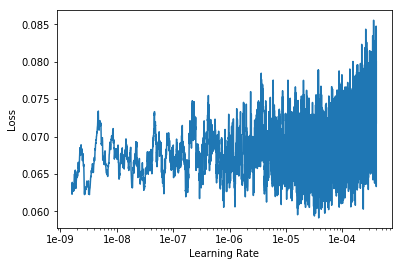

In [100]:
learn.recorder.plot()